# Music Matching

**Objetivos**
1. Implementar **um** algoritmo de segmentação de músicas

**Resultado Esperado**
1. Saber segmentar uma música simples
1. Entender o resultado via previsão, revocação e F1

In [ ]:
from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

plt.rcParams['axes.labelsize']  = 16
plt.rcParams['axes.titlesize']  = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2

plt.ion()

## Introdução

Neste notebook vamos explorar a tarefa de **segmentação de músicas**. Nesta tareda, dada uma gravação musical, o objetivo é identificar elementos estruturais importantes e segmentar temporalmente a gravação de acordo com tais elementos. 

Nosso ponto de partida serão bases de dados já anotadas além de **matrizes de similaridade**. Abaixo temos um exemplo do que podemos esperar \[[1](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S2_SSM.html)\]:

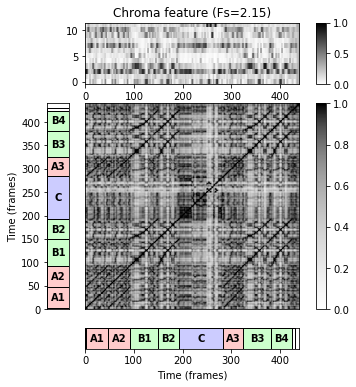

A imagem acima mostra três conceitos. Na parte superior temos os atributos do [cromagrama](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S1_SpecLogFreq-Chromagram.html), no centro temos uma [matriz de similaridade](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S2_SSM.html), por fim as anotações estão representadas do lado da matriz. Vamos falar um pouco mais delas abaixo.

## Base de Dados

Para a tarefa de segmentação, é comum partimos de uma base de dados já anotada. Para o notebook de hoje, vamos fazer uso de algumas músicas da base [Salami](https://github.com/DDMAL/salami-data-public). Para baixar tais música, pode-se fazer uso dos IDs do YouTube descritos no [Matching Salami](https://github.com/jblsmith/matching-salami). Assim como no notebook anterior, a ferramenta [youtube-dl](https://youtube-dl.org/) cuida de baixar mp3s do YouTube.

A base Salami foi anotada manualmente. Seguindo um guia comum, as letras  A, B, C, D, E, ...: indicam frases musicais em grande escala, isto é, ideias ou assuntos que podem ser diferenciados com base no material rítmico, melódico ou harmônico. A letra Z tem um uso especial para destacar seções distoantes como diálogos ou aplausos. Sempre uma seção se repete, anotamos com a mesma letra e um número, por exemplo A#. Na figura acima, temos três seções A (A1, A2 e A3). Caso uma seção tenha sub-seções, os anotadores usam letras minúsculas (a, b, c, ...). No notebook vamos focar nas anotações em maior escala mesmo (maiúsculas).

Para certos estilos músicas, as seções são posteriormente rotuladas para termos comuns do mundo da música como: *ponte*, *verso*, *refrão*, etc. Portanto, para simplificar nosso entendimento, não só vamos fazer uso das seções em maior escala *como também* vamos converter as mesmas para rótulos. É importante deixar claro que o livro da matéria não usa rótulos. 

O código abaixo lê três músicas de estilos bem diferentes do Salami.

In [ ]:
songs = {'3GsynTrMJeg':os.path.join('salami',
                                    'Violin Sonata - III. Finale très animé-3GsynTrMJeg.mp3'), 
         'IBdrzoz9o0o':os.path.join('salami',
                                    'Beastie Boys - Pass The Mic - Solid Gold Hits-IBdrzoz9o0o.mp3'),
         'KMwWP5nlxqA':os.path.join('salami',
                                    'The Black Keys - When the lights go out-KMwWP5nlxqA.mp3')}

In [ ]:
songs

In [ ]:
df = pd.read_csv('salami/salami_youtube_pairings.csv')
df = df.set_index('youtube_id')
df = df.sort_index()
df.head()

In [ ]:
df.loc['KMwWP5nlxqA']

A função abaixo já converte um id do YouTube para as anotações.

In [ ]:
def get_annotations(df, youtube_id):
    salami_id = int(df.loc[youtube_id]['salami_id'])
    folder = os.path.join('salami',
                          'salami-data-public',
                          'annotations',
                          f'{salami_id}',
                          'parsed')
    file_one = os.path.join(folder, 'textfile1_functions.txt')
    file_two = os.path.join(folder, 'textfile2_functions.txt')
    
    df_one = pd.read_csv(file_one, sep='\t', names=['time', 'section'], header=None)
    df_two = pd.read_csv(file_two, sep='\t', names=['time', 'section'], header=None)
    
    return df_one, df_two

Para simplificar nossa vida, criei uma função de plotar o cromagrama.

In [ ]:
def plot_chroma(chroma, hop_length):
    fig, ax = plt.subplots(figsize=(1.618 * 16, 16))
    img = librosa.display.specshow(chroma,
                                   hop_length=hop_length,
                                   y_axis='chroma',
                                   x_axis='time',
                                   ax=ax)
    fig.colorbar(img, ax=ax)
    fig.show()

## Músicas

Seguem as músicas que vamos estudar.

1. **Rock** The Black Keys - When the lights go out
1. **Rap** Beastie Boys - Pass The Mic
1. **Clássica** Violin Sonata - III. Finale très animé

Observe como as seções das mesmas são bem diferentes.


### Black Keys

In [ ]:
ipd.YouTubeVideo('KMwWP5nlxqA')

In [ ]:
annot_one, annot_two = get_annotations(df, 'KMwWP5nlxqA')
annot_one

In [ ]:
annot_two

### Beastie Boys

In [ ]:
ipd.YouTubeVideo('IBdrzoz9o0o')

In [ ]:
annot_one, annot_two = get_annotations(df, 'IBdrzoz9o0o')
annot_one

In [ ]:
annot_two

### Sonata

In [ ]:
ipd.YouTubeVideo('3GsynTrMJeg')

In [ ]:
annot_one, annot_two = get_annotations(df, '3GsynTrMJeg')
annot_one

In [ ]:
annot_two

## Carregando os Cromagramas

O código abaixo carrega os cromagramas. Para garantir uma suavização, fazemos uso da implementação [Q-Quantized](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C7/C7S2_CENS.html). Além do mais, configuramos o `hop_length` para que cada matriz de similaridade tenha um tamanho *que caiba na memória*. O `hop_length` define o número de janelas (não em tempo, sim em posições do vetor de onda) que serao agregadas para coluna da matriz.

Como nossa música tem uma taxa de amostragem `sr` por segundos, ao setar o `hop_length=sr` ficamos com uma matriz onde as colunas são os segundos da música. ***Porém, o librosa não permite isso para o cromagrama :-(**. Coloquei um valor alto base de 2 (necessário).

In [ ]:
wave_beastie, sr_beastie = librosa.load(songs['IBdrzoz9o0o'])
chroma_beastie = librosa.feature.chroma_cens(wave_beastie, sr=sr_beastie, hop_length=4096)
plot_chroma(chroma_beastie, hop_length=4096)
print(chroma_beastie.shape)

In [ ]:
wave_sonata, sr_sonata = librosa.load(songs['3GsynTrMJeg'])
chroma_sonata = librosa.feature.chroma_cens(wave_sonata, sr=sr_sonata, hop_length=4096)
plot_chroma(chroma_sonata, hop_length=4096)
print(chroma_sonata.shape)

In [ ]:
wave_bkeys, sr_bkeys = librosa.load(songs['KMwWP5nlxqA'])
chroma_bkeys = librosa.feature.chroma_cens(wave_bkeys, sr=sr_bkeys, hop_length=4096)
plot_chroma(chroma_bkeys, hop_length=4096)
print(chroma_bkeys.shape)

## Matriz de Similaridade

O código abaixo retorna a matriz de similaridade entre todos os instantes da música. Agora, sua tarefa é com base em tal matriz prover uma segmentação semântica da música. Para fazer tal tarefa funcionar de forma eficaz, **talvez** você tenha que escolher entre as diferentes formas de pre-processamento listados em [C4](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4.html).

In [ ]:
def cosine_similarity(X, Y):
    '''
    Similaridade de coseno de todos com todos
    '''
    l2_x = (X * X).sum(axis=0)
    l2_y = (Y * Y).sum(axis=0)
    X = X / l2_x
    Y = Y / l2_y
    return X.T.dot(Y)

In [ ]:
S = cosine_similarity(chroma_sonata, chroma_sonata)
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(S[::-1])

Sinta-se livre para implementar outras formas de pré-processamento (ou até nenhuma se achar suficiente).

## Problema

Acima vimos a matriz pré-processada. Como sua tarefa é na segmentação, sua tarefa é:


1. Implemente o método descrito em [C4S4](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S4_NoveltySegmentation.html). 
1. Implemente o método descrito em [C4S5](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C4/C4S4_StructureFeature.html). 


**Eu não tenho nenhum problema em você copiar o código do kernel em C4S4 ou o código do time-lag em C4S5. Porém, implemente a detecção e a avaliação você mesmo. Escolhe entre métodos de pré-processamento se necessário**.

3. Mensure a precisão, revocação e f1 para as três músicas. Como existem 2 anotadores por estilo, você terá 6 conjuntos de resultados!

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

4. Responda: Em qual estilo o método funcionou melhor? Você tem alguma explicação? Compare com outras músicas do SALAMI caso queira.

> Resposta aqui